<a href="https://colab.research.google.com/github/Vedparkash5/COGS_189_Final-Project/blob/main/cleaning_Final189.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The data we used is from the UCI Machine Learning Reository
https://archive.ics.uci.edu/ml/datasets/eeg+database

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from cycler import cycler
import scipy.io
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import seaborn as sns; sns.set_theme()
import os
import pickle
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score
import tensorflow as tf
from tensorflow import keras
 

#Exploratory Data Analysis

In [2]:
# Read data - Steven
data = pd.read_csv('epilepsy.csv.txt')
# Create binary label whether patient is having a seizure - Steven
data['label'] = data['y'].apply(lambda x: 1 if x == 1 else 0)
# drop column - Steven
data.pop('y')
data

,Unnamed: 0,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X25,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39,...,X140,X141,X142,X143,X144,X145,X146,X147,X148,X149,X150,X151,X152,X153,X154,X155,X156,X157,X158,X159,X160,X161,X162,X163,X164,X165,X166,X167,X168,X169,X170,X171,X172,X173,X174,X175,X176,X177,X178,label
0,X21.V1.791,135,190,229,223,192,125,55,-9,-33,-38,-10,35,64,113,152,164,127,50,-47,-121,-138,-125,-101,-50,11,39,24,48,64,46,13,-19,-61,-96,-130,-132,-116,-115,-71,...,54,90,111,107,64,32,18,-25,-69,-65,-44,-33,-57,-88,-114,-130,-114,-83,-53,-79,-72,-85,-109,-98,-72,-65,-63,-11,10,8,-17,-15,-31,-77,-103,-127,-116,-83,-51,0
1,X15.V1.924,386,382,356,331,320,315,307,272,244,232,237,258,212,2,-267,-605,-850,-1001,-1109,-1090,-967,-746,-464,-152,118,318,427,473,485,447,397,339,312,314,326,335,332,324,310,...,27,146,229,269,297,307,303,305,306,307,280,231,159,85,51,43,62,63,63,69,89,123,136,127,102,95,105,131,163,168,164,150,146,152,157,156,154,143,129,1
2,X8.V1.1,-32,-39,-47,-37,-32,-36,-57,-73,-85,-94,-99,-94,-96,-104,-103,-92,-75,-69,-69,-53,-37,-14,-10,-39,-78,-102,-98,-80,-54,-40,-35,-39,-32,-13,7,34,41,33,6,...,-82,-107,-126,-124,-108,-84,-68,-61,-56,-63,-62,-33,1,28,45,37,48,62,80,66,23,-11,-39,-44,-42,-45,-48,-42,-6,29,57,64,48,19,-12,-30,-35,-35,-36,0
3,X16.V1.60,-105,-101,-96,-92,-89,-95,-102,-100,-87,-79,-72,-68,-74,-80,-83,-73,-68,-61,-58,-59,-64,-79,-84,-97,-94,-84,-77,-75,-72,-68,-76,-76,-72,-67,-69,-69,-69,-67,-68,...,-69,-66,-74,-69,-61,-51,-45,-45,-49,-58,-64,-78,-80,-90,-87,-83,-78,-64,-38,-22,-29,-42,-51,-68,-71,-69,-69,-74,-74,-80,-82,-81,-80,-77,-85,-77,-72,-69,-65,0
4,X20.V1.54,-9,-65,-98,-102,-78,-48,-16,0,-21,-59,-90,-103,-84,-43,-9,3,-21,-60,-96,-103,-75,-29,14,55,78,73,28,-13,-43,-68,-78,-75,-55,-41,-19,-20,-29,-36,-20,...,38,26,10,-4,-13,-8,0,10,19,29,57,63,45,7,-13,-23,-9,9,11,3,-1,-2,4,18,27,27,14,15,11,10,4,2,-12,-32,-41,-65,-83,-89,-73,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11495,X22.V1.114,-22,-22,-23,-26,-36,-42,-45,-42,-45,-49,-57,-64,-73,-79,-76,-70,-63,-57,-57,-50,-45,-34,-33,-32,-30,-24,-24,-18,-9,-2,0,2,-3,-5,-13,-23,-39,-53,-59,...,45,55,60,69,68,58,54,44,40,38,39,39,32,23,22,14,13,15,18,20,20,25,28,29,29,29,26,24,24,20,15,16,12,5,-1,-18,-37,-47,-48,0
11496,X19.V1.354,-47,-11,28,77,141,211,246,240,193,136,78,8,-66,-132,-180,-210,-227,-225,-212,-192,-168,-144,-117,-88,-54,-21,6,29,46,60,76,92,110,128,152,171,150,91,21,...,69,58,38,16,25,75,165,260,343,406,456,471,461,412,319,175,-5,-171,-293,-357,-378,-370,-346,-316,-278,-241,-201,-162,-126,-94,-65,-33,-7,14,27,48,77,117,170,1
11497,X8.V1.28,14,6,-13,-16,10,26,27,-9,4,14,-1,-10,14,44,77,61,42,32,29,22,26,35,81,66,50,57,91,121,111,73,38,23,35,21,11,-12,2,17,61,...,-90,-62,-38,-40,-21,-23,-11,-4,-9,-22,-42,-49,-48,-40,-40,-46,-43,-67,-67,-50,-18,-14,-39,-74,-86,-75,-68,-57,-78,-42,-65,-48,-61,-62,-67,-30,-2,-1,-8,0
11498,X10.V1.932,-40,-25,-9,-12,-2,12,7,19,22,29,22,6,1,-28,-37,-35,-35,-45,-64,-105,-140,-157,-157,-147,-153,-147,-126,-112,-83,-56,-41,-40,-38,-34,-47,-41,-40,-42,-49,...,-98,-77,-60,-73,-88,-97,-118,-108,-100,-97,-91,-109,-122,-134,-137,-107,-95,-67,-54,-40,-31,-19,7,22,46,68,87,97,105,114,121,135,148,143,116,86,68,59,55,0


In [3]:
# Check for missing data - Steven
data.isna().sum().sum()
# No missing data, means we don't have to impute

0

In [4]:
# 11500 rows, 20% of patients have seizures using the mean - Steven
data['label'].describe()

count    11500.000000
mean         0.200000
std          0.400017
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: label, dtype: float64

 80% of patients did not have a seizure, so we might need to do something to balance it out, ex) drop 40% of the non-seizure data - Steven

In [5]:
# sorting the data by label and the first dropping 3680 rows non seizure rows, 40% of the non seizured patients - Edmundo
data = data.sort_values(by = 'label').reset_index(drop = True)
data = data.drop(data.index[:3680])

In [6]:
data.label.value_counts() 

0    5520
1    2300
Name: label, dtype: int64

In [7]:
data.shape

(7820, 180)

### PCA Model

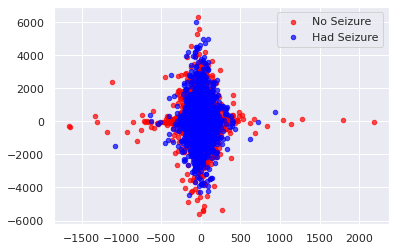

In [8]:
%matplotlib inline

# PCA 
from sklearn.decomposition import PCA

# plots
import matplotlib.pyplot as plt
# drop first column and label
X = data.drop(columns=[data.columns[0], 'label']).to_numpy()
pca = PCA(n_components=2)
# Reduced Data
pca_data = pca.fit_transform(X).reshape(2, 7820)
pca_x = pca_data[0]
pca_y = pca_data[1]

# set color of scatter points by label
cdict = {0: 'red', 1: 'blue'}


fig, ax = plt.subplots()
for label in np.unique(data['label']):
  # get indexes of the label
    ix = data['label'] == label
    if label == 0:
      patients = 'No Seizure'
    else:
      patients = 'Had Seizure'
    ax.scatter(pca_x[ix], pca_y[ix], c = cdict[label], label = patients, s = 20, alpha=.7)
ax.legend()
plt.show()

# Plot shows how the PCA looks like for those with seizures vs those without - Steven

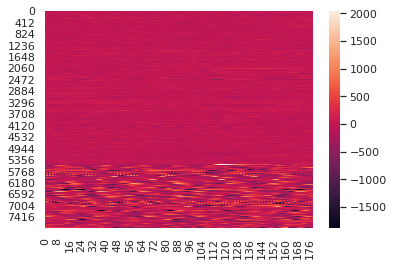

In [9]:
ax = sns.heatmap(X)
# Might be able to show the correlation between each signal and the label, but it will probably be really hard to read. - Steven 

###KNN Model



In [10]:
# Create X and y
X = data.drop(columns=['Unnamed: 0', 'label'])
y = data['label']

# Standard scale X
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Create train, validation, and test sets: 60:20:20
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.6, random_state=42)

X_test, X_valid, y_test, y_valid = train_test_split(X, y, test_size=0.5, random_state=42)

In [11]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
import warnings
warnings.filterwarnings('ignore')
from sklearn.neighbors import KNeighborsClassifier

In [12]:
%%time
# 5min 50s
# KNN

#setting params
n_params = [1, 2, 3 ,4 ,5 ,6 ,7 ,8 ,9, 10, 20, 50, 70, 100, 150, 200, 250, 300]
train_recalls = []
valid_recalls = []


train_accs = []
valid_accs = []

# Get scores for each parameter
for n in n_params:
  #print('n_param: ', n)
  knn= Pipeline([('KNN', KNeighborsClassifier(n_neighbors = n))])
  knn.fit(X_train, y_train)

  y_train_preds = knn.predict(X_train)
  y_valid_preds = knn.predict(X_valid)

  knn_train_recall = recall_score(y_train,y_train_preds)
  knn_train_acc = accuracy_score(y_train, y_train_preds)
  train_recalls.append(knn_train_recall)
  train_accs.append(knn_train_acc)


  knn_valid_recall = recall_score(y_valid,y_valid_preds)
  knn_valid_acc = accuracy_score(y_valid, y_valid_preds)
  valid_recalls.append(knn_valid_recall)
  valid_accs.append(knn_valid_acc)

CPU times: user 2min 31s, sys: 29.7 ms, total: 2min 31s
Wall time: 2min 31s


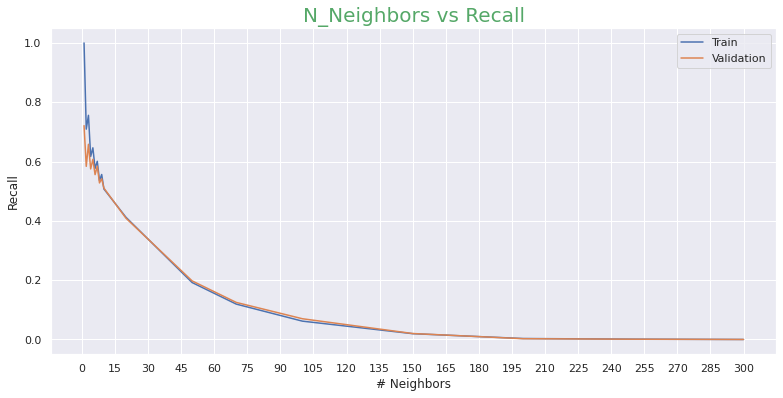

In [13]:
fig, ax = plt.subplots(figsize=(13,6))
x = np.arange(5, 101, 5)
ax = sns.lineplot(x=n_params, y=train_recalls)
sns.lineplot(x=n_params, y=valid_recalls, ax=ax)
ax.legend(labels=['Train', 'Validation'], bbox_to_anchor=(1, 1))
ax.set_xlabel('# Neighbors')
ax.set_ylabel('Recall')
ax.set_xticks(np.arange(0,301, 15))
ax.set_title('N_Neighbors vs Recall', c='g', fontdict={'c':'blue', 'fontsize':20})

plt.show()

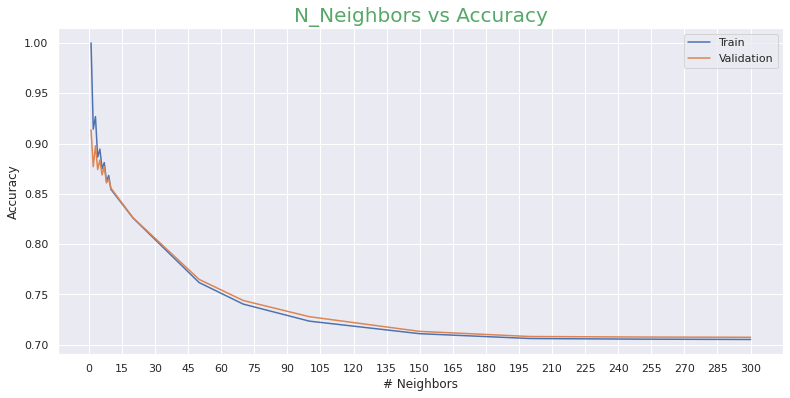

In [14]:
fig, ax = plt.subplots(figsize=(13,6))
x = np.arange(5, 101, 5)
ax = sns.lineplot(x=n_params, y=train_accs)
sns.lineplot(x=n_params, y=valid_accs, ax=ax)
ax.legend(labels=['Train', 'Validation'], bbox_to_anchor=(1, 1))
ax.set_xlabel('# Neighbors')
ax.set_ylabel('Accuracy')
ax.set_xticks(np.arange(0,301, 15))
ax.set_title('N_Neighbors vs Accuracy', c='g', fontdict={'c':'blue', 'fontsize':20})

plt.show()

###Logistic Regression

In [15]:
%%time 
from sklearn.linear_model import LogisticRegression

# Logistic Regression
train_recalls = []
valid_recalls = []
train_accs = []
valid_accs = []

C_params = np.arange(0.05, 1.05, .05)

for c in C_params:
  lr = LogisticRegression(random_state = 69, C = c)
  pipe = Pipeline([('lr', lr)])

  lr.fit(X_train, y_train)

  y_train_preds = lr.predict(X_train)
  y_valid_preds = lr.predict(X_valid)

  lr_train_recall= recall_score(y_train,y_train_preds)
  lr_valid_recall= recall_score(y_valid,y_valid_preds)

  lr_train_acc = accuracy_score(y_train, y_train_preds)
  lr_valid_acc = accuracy_score(y_valid, y_valid_preds)

  train_recalls.append(lr_train_recall)
  valid_recalls.append(lr_valid_recall)

  train_accs.append(lr_train_acc)
  valid_accs.append(lr_valid_acc)

CPU times: user 3.6 s, sys: 1.77 s, total: 5.38 s
Wall time: 2.77 s


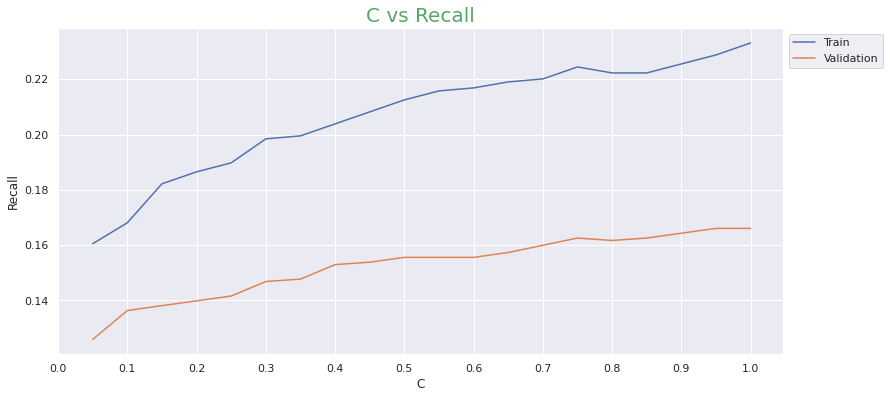

In [16]:
fig, ax = plt.subplots(figsize=(13,6))
ax = sns.lineplot(x=C_params, y=train_recalls)
sns.lineplot(x=C_params, y=valid_recalls, ax=ax)
ax.legend(labels=['Train', 'Validation'], bbox_to_anchor=(1, 1))
ax.set_xlabel('C')
ax.set_ylabel('Recall')
ax.set_xticks(np.arange(0, 1.1, .1))
ax.set_title('C vs Recall', c='g', fontdict={'c':'blue', 'fontsize':20})

plt.show()

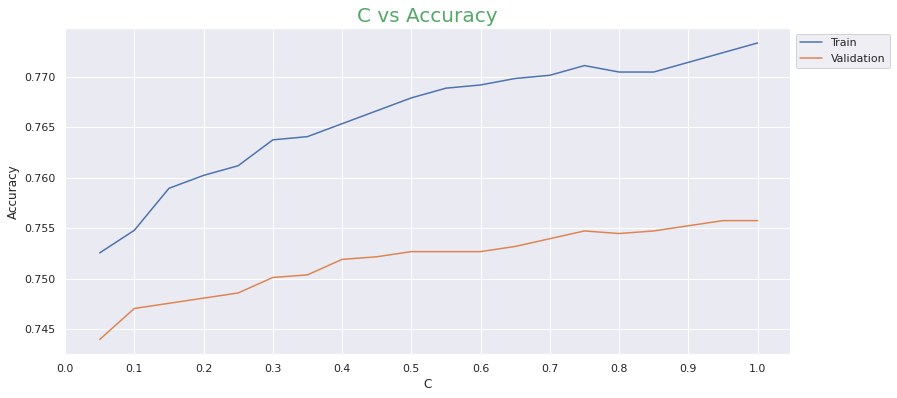

In [17]:
fig, ax = plt.subplots(figsize=(13,6))
ax = sns.lineplot(x=C_params, y=train_accs)
sns.lineplot(x=C_params, y=valid_accs, ax=ax)
ax.legend(labels=['Train', 'Validation'], bbox_to_anchor=(1, 1))
ax.set_xlabel('C')
ax.set_ylabel('Accuracy')
ax.set_xticks(np.arange(0, 1.1, .1))
ax.set_title('C vs Accuracy', c='g', fontdict={'c':'blue', 'fontsize':20})

plt.show()

### Stochastic Gradient Descent

In [18]:
from sklearn.linear_model import SGDClassifier

train_recalls = []
valid_recalls = []
train_accs = []
valid_accs = []

alpha_params = [.000001, .00001, .0001, .001, .01]

for a in alpha_params:
  SGDC = SGDClassifier(loss = 'log',alpha = a)
  SGDC.fit(X_train, y_train)

  y_train_preds = SGDC.predict(X_train)
  y_valid_preds = SGDC.predict(X_valid)

  SGDC_train_recall= recall_score(y_train,y_train_preds)
  SGDC_valid_recall= recall_score(y_valid,y_valid_preds)

  SGDC_train_acc = accuracy_score(y_train, y_train_preds)
  SGDC_valid_acc = accuracy_score(y_valid, y_valid_preds)

  train_recalls.append(SGDC_train_recall)
  valid_recalls.append(SGDC_valid_recall)

  train_accs.append(SGDC_train_acc)
  valid_accs.append(SGDC_valid_acc)

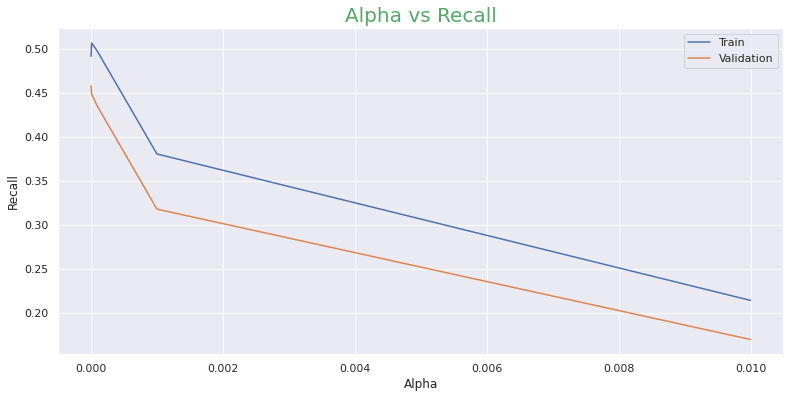

In [19]:
fig, ax = plt.subplots(figsize=(13,6))
ax = sns.lineplot(x=alpha_params, y=train_recalls)
sns.lineplot(x=alpha_params, y=valid_recalls, ax=ax)
ax.legend(labels=['Train', 'Validation'], bbox_to_anchor=(1, 1))
ax.set_xlabel('Alpha')
ax.set_ylabel('Recall')
#ax.set_xticks(np.arange(0, 1.1, .1))
ax.set_title('Alpha vs Recall', c='g', fontdict={'c':'blue', 'fontsize':20})

plt.show()

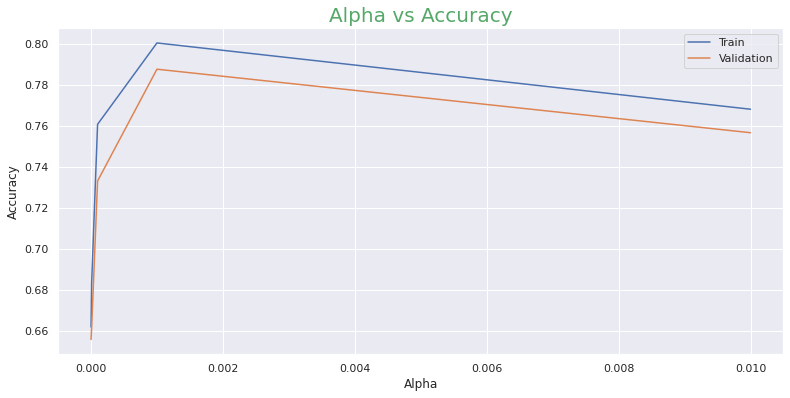

In [20]:
fig, ax = plt.subplots(figsize=(13,6))
ax = sns.lineplot(x=alpha_params, y=train_accs)
sns.lineplot(x=alpha_params, y=valid_accs, ax=ax)
ax.legend(labels=['Train', 'Validation'], bbox_to_anchor=(1, 1))
ax.set_xlabel('Alpha')
ax.set_ylabel('Accuracy')
#ax.set_xticks(np.arange(0, 1.1, .1))
ax.set_title('Alpha vs Accuracy', c='g', fontdict={'c':'blue', 'fontsize':20})

plt.show()

### Gaussian Naive-Bayes

In [21]:
from sklearn.naive_bayes import GaussianNB

train_recalls = []
valid_recalls = []
train_accs = []
valid_accs = []

var_params = [1e-7, 1e-8, 1e-9, 1e-10, 1e-11]

for var in var_params:
  nb = GaussianNB(var_smoothing=var)
  nb.fit(X_train, y_train)

  y_train_preds = nb.predict(X_train)
  y_valid_preds = nb.predict(X_valid)

  nb_train_recall= recall_score(y_train,y_train_preds)
  nb_valid_recall= recall_score(y_valid,y_valid_preds)

  nb_train_acc = accuracy_score(y_train, y_train_preds)
  nb_valid_acc = accuracy_score(y_valid, y_valid_preds)

  train_recalls.append(nb_train_recall)
  valid_recalls.append(nb_valid_recall)

  train_accs.append(nb_train_acc)
  valid_accs.append(nb_valid_acc)

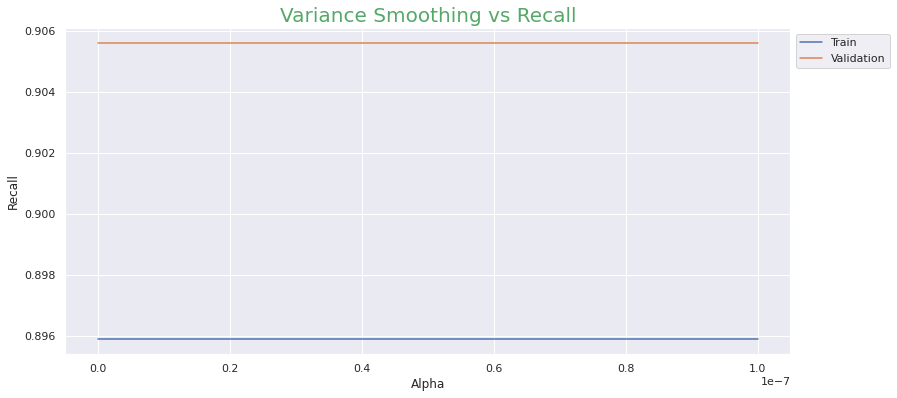

In [22]:
fig, ax = plt.subplots(figsize=(13,6))
ax = sns.lineplot(x=var_params, y=train_recalls)
sns.lineplot(x=var_params, y=valid_recalls, ax=ax)
ax.legend(labels=['Train', 'Validation'], bbox_to_anchor=(1, 1))
ax.set_xlabel('Alpha')
ax.set_ylabel('Recall')
#ax.set_xticks(np.arange(0, 1.1, .1))
ax.set_title('Variance Smoothing vs Recall', c='g', fontdict={'c':'blue', 'fontsize':20})

plt.show()

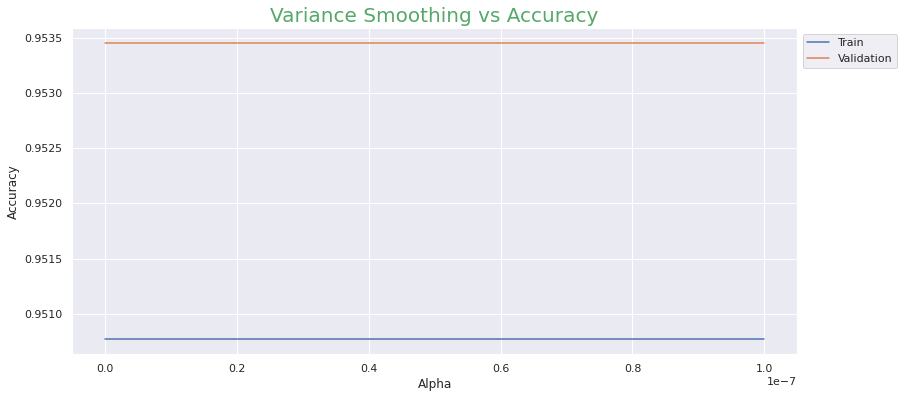

In [23]:
fig, ax = plt.subplots(figsize=(13,6))
ax = sns.lineplot(x=var_params, y=train_accs)
sns.lineplot(x=var_params, y=valid_accs, ax=ax)
ax.legend(labels=['Train', 'Validation'], bbox_to_anchor=(1, 1))
ax.set_xlabel('Alpha')
ax.set_ylabel('Accuracy')
#ax.set_xticks(np.arange(0, 1.1, .1))
ax.set_title('Variance Smoothing vs Accuracy', c='g', fontdict={'c':'blue', 'fontsize':20})

plt.show()

### Random Forest

In [24]:
from sklearn.ensemble import RandomForestClassifier

train_recalls = []
valid_recalls = []
train_accs = []
valid_accs = []

depth_params = [2, 3, 5, 7, 8, 10]

for depth in depth_params:
  rf = RandomForestClassifier(max_depth = depth, random_state = 69)
  rf.fit(X_train, y_train)

  y_train_preds = rf.predict(X_train)
  y_valid_preds = rf.predict(X_valid)

  rf_train_recall= recall_score(y_train,y_train_preds)
  rf_valid_recall= recall_score(y_valid,y_valid_preds)

  rf_train_acc = accuracy_score(y_train, y_train_preds)
  rf_valid_acc = accuracy_score(y_valid, y_valid_preds)

  train_recalls.append(rf_train_recall)
  valid_recalls.append(rf_valid_recall)

  train_accs.append(rf_train_acc)
  valid_accs.append(rf_valid_acc)

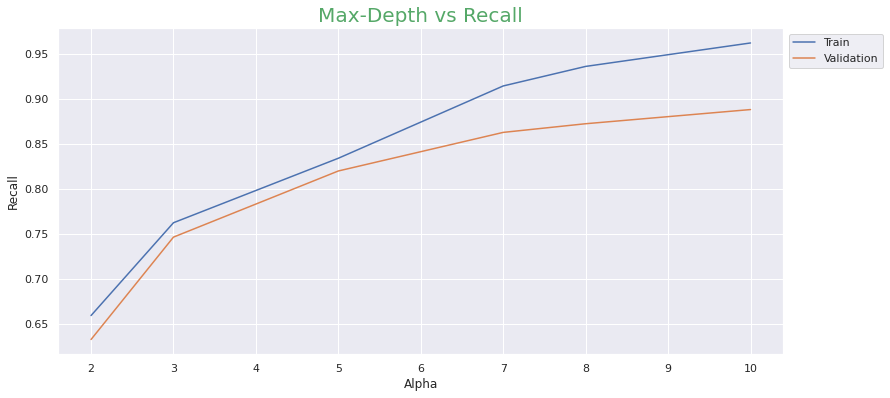

In [25]:
fig, ax = plt.subplots(figsize=(13,6))
ax = sns.lineplot(x=depth_params, y=train_recalls)
sns.lineplot(x=depth_params, y=valid_recalls, ax=ax)
ax.legend(labels=['Train', 'Validation'], bbox_to_anchor=(1, 1))
ax.set_xlabel('Alpha')
ax.set_ylabel('Recall')
#ax.set_xticks(np.arange(0, 1.1, .1))
ax.set_title('Max-Depth vs Recall', c='g', fontdict={'c':'blue', 'fontsize':20})

plt.show()

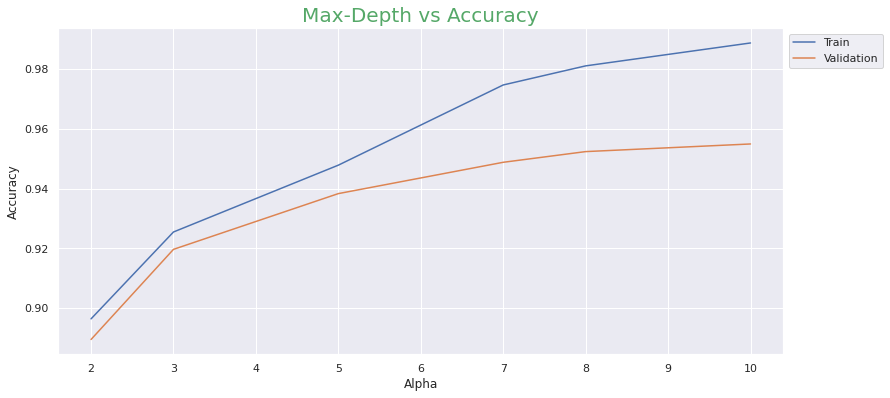

In [26]:
fig, ax = plt.subplots(figsize=(13,6))
ax = sns.lineplot(x=depth_params, y=train_accs)
sns.lineplot(x=depth_params, y=valid_accs, ax=ax)
ax.legend(labels=['Train', 'Validation'], bbox_to_anchor=(1, 1))
ax.set_xlabel('Alpha')
ax.set_ylabel('Accuracy')
#ax.set_xticks(np.arange(0, 1.1, .1))
ax.set_title('Max-Depth vs Accuracy', c='g', fontdict={'c':'blue', 'fontsize':20})

plt.show()

### ANN

In [27]:
labels = data['label']
features = data.drop(columns=['label'])

In [28]:
labels[0:5]

3680    0
3681    0
3682    0
3683    0
3684    0
Name: label, dtype: int64

In [29]:
features[0:5]

,Unnamed: 0,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X25,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39,...,X139,X140,X141,X142,X143,X144,X145,X146,X147,X148,X149,X150,X151,X152,X153,X154,X155,X156,X157,X158,X159,X160,X161,X162,X163,X164,X165,X166,X167,X168,X169,X170,X171,X172,X173,X174,X175,X176,X177,X178
3680,X6.V1.80,17,29,46,51,40,26,21,48,62,51,37,27,31,38,59,61,34,-3,-36,-51,-51,-41,-44,-60,-71,-55,-38,-17,-1,13,18,17,2,-14,-25,-15,-3,-3,-18,...,-35,-52,-62,-72,-66,-48,-48,-56,-61,-51,-28,-3,10,7,-1,-22,-47,-79,-93,-90,-98,-76,-42,1,14,21,20,32,46,60,56,46,24,14,-4,-20,-44,-63,-74,-63
3681,X2.V1.8,9,4,-4,-6,-7,-9,-14,0,10,4,-12,-30,-44,-37,-26,-16,-14,5,6,-2,-12,-25,-23,-27,-22,-24,-21,-14,-8,-14,-27,-34,-32,-23,-6,16,27,31,34,...,22,43,59,50,28,1,-18,-24,-16,-21,-33,-32,-26,-5,10,27,24,23,25,16,13,14,28,28,26,18,17,15,6,4,0,10,16,6,1,7,24,16,3,-1
3682,X18.V1.3,2,-2,-15,-10,12,59,42,44,18,6,24,40,49,36,31,12,30,-11,-24,-40,-31,-28,-30,-57,-83,-111,-103,-71,-26,2,2,-26,-3,38,17,10,-29,-25,-13,...,20,-6,-25,-41,-47,-35,-27,-25,-2,29,54,55,57,62,56,36,-4,-32,-27,-19,6,5,12,26,20,39,33,35,-21,-51,-42,-48,-46,-61,-50,-27,23,64,98,100
3683,X7.V1.715,-39,-35,-22,-20,-21,-24,-21,-20,-22,-24,-23,-25,-33,-28,-29,-22,-25,-27,-32,-35,-39,-45,-47,-52,-45,-46,-42,-37,-36,-33,-32,-23,-27,-29,-34,-37,-37,-42,-41,...,37,37,31,26,22,19,8,-5,-17,-21,-15,-9,-9,-13,-9,-2,6,7,4,-1,0,7,20,23,18,9,-14,-29,-32,-34,-31,-31,-15,-3,3,4,-2,-7,-4,-1
3684,X11.V1.451,-15,-15,-9,-8,-7,-5,-3,4,15,25,28,30,27,21,19,11,4,-13,-13,-20,-23,-25,-17,-10,-12,-6,-8,1,2,4,0,6,25,35,23,3,-9,-13,-13,...,51,35,11,-11,-30,-25,0,41,81,111,122,109,103,97,93,90,74,37,-24,-79,-125,-147,-145,-121,-78,-25,42,92,121,143,166,182,177,146,73,-15,-95,-141,-165,-167


In [30]:
features.shape

(7820, 179)

In [31]:
features = pd.get_dummies(features)
features[0:5]

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X25,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39,X40,...,Unnamed: 0_X9.V1.882,Unnamed: 0_X9.V1.884,Unnamed: 0_X9.V1.89,Unnamed: 0_X9.V1.892,Unnamed: 0_X9.V1.894,Unnamed: 0_X9.V1.9,Unnamed: 0_X9.V1.90,Unnamed: 0_X9.V1.901,Unnamed: 0_X9.V1.904,Unnamed: 0_X9.V1.911,Unnamed: 0_X9.V1.912,Unnamed: 0_X9.V1.915,Unnamed: 0_X9.V1.916,Unnamed: 0_X9.V1.917,Unnamed: 0_X9.V1.92,Unnamed: 0_X9.V1.922,Unnamed: 0_X9.V1.924,Unnamed: 0_X9.V1.934,Unnamed: 0_X9.V1.942,Unnamed: 0_X9.V1.943,Unnamed: 0_X9.V1.944,Unnamed: 0_X9.V1.951,Unnamed: 0_X9.V1.953,Unnamed: 0_X9.V1.954,Unnamed: 0_X9.V1.96,Unnamed: 0_X9.V1.961,Unnamed: 0_X9.V1.962,Unnamed: 0_X9.V1.964,Unnamed: 0_X9.V1.97,Unnamed: 0_X9.V1.972,Unnamed: 0_X9.V1.974,Unnamed: 0_X9.V1.98,Unnamed: 0_X9.V1.983,Unnamed: 0_X9.V1.984,Unnamed: 0_X9.V1.99,Unnamed: 0_X9.V1.991,Unnamed: 0_X9.V1.994,Unnamed: 0_X9.V11,Unnamed: 0_X9.V12,Unnamed: 0_X9.V14
3680,17,29,46,51,40,26,21,48,62,51,37,27,31,38,59,61,34,-3,-36,-51,-51,-41,-44,-60,-71,-55,-38,-17,-1,13,18,17,2,-14,-25,-15,-3,-3,-18,-19,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3681,9,4,-4,-6,-7,-9,-14,0,10,4,-12,-30,-44,-37,-26,-16,-14,5,6,-2,-12,-25,-23,-27,-22,-24,-21,-14,-8,-14,-27,-34,-32,-23,-6,16,27,31,34,27,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3682,2,-2,-15,-10,12,59,42,44,18,6,24,40,49,36,31,12,30,-11,-24,-40,-31,-28,-30,-57,-83,-111,-103,-71,-26,2,2,-26,-3,38,17,10,-29,-25,-13,7,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3683,-39,-35,-22,-20,-21,-24,-21,-20,-22,-24,-23,-25,-33,-28,-29,-22,-25,-27,-32,-35,-39,-45,-47,-52,-45,-46,-42,-37,-36,-33,-32,-23,-27,-29,-34,-37,-37,-42,-41,-48,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3684,-15,-15,-9,-8,-7,-5,-3,4,15,25,28,30,27,21,19,11,4,-13,-13,-20,-23,-25,-17,-10,-12,-6,-8,1,2,4,0,6,25,35,23,3,-9,-13,-13,-8,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [32]:
features = features.values.astype('float32')
labels = labels.values.astype('float32')

In [33]:
print(features)
features[0].shape

[[  17.   29.   46. ...    0.    0.    0.]
 [   9.    4.   -4. ...    0.    0.    0.]
 [   2.   -2.  -15. ...    0.    0.    0.]
 ...
 [  73.   73.   73. ...    0.    0.    0.]
 [ -78.  -93.  -51. ...    0.    0.    0.]
 [-624. -596. -554. ...    0.    0.    0.]]


(7998,)

In [34]:
features_train,features_test, labels_train, labels_test = train_test_split(features, labels, test_size = 0.2)
features_train, features_validation, labels_train, labels_validation = train_test_split(features_train, labels_train, test_size = 0.2)
model = keras.Sequential([keras.layers.Dense(32, input_shape=(7998,)),
                          keras.layers.Dense(20, activation=tf.nn.relu),
                         keras.layers.Dense(2,activation='softmax')])
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['acc'])


In [35]:
history1 = model.fit(features_train, labels_train, epochs=20, validation_data=(features_validation, labels_validation))
prediction_features = model.predict(features_test)
accuracy = model.evaluate(features_test, labels_test)


Epoch 1/20
157/157 [==============================] - 1s 7ms/step - loss: 9.5015 - acc: 0.6469 - val_loss: 4.2220 - val_acc: 0.6605
Epoch 2/20
157/157 [==============================] - 1s 4ms/step - loss: 2.8478 - acc: 0.7330 - val_loss: 2.4010 - val_acc: 0.7005
Epoch 3/20
157/157 [==============================] - 1s 4ms/step - loss: 1.6984 - acc: 0.7752 - val_loss: 1.9110 - val_acc: 0.7580
Epoch 4/20
157/157 [==============================] - 1s 4ms/step - loss: 1.0962 - acc: 0.8169 - val_loss: 1.3493 - val_acc: 0.7700
Epoch 5/20
157/157 [==============================] - 1s 4ms/step - loss: 0.8508 - acc: 0.8213 - val_loss: 1.1423 - val_acc: 0.8171
Epoch 6/20
157/157 [==============================] - 1s 4ms/step - loss: 0.6285 - acc: 0.8575 - val_loss: 1.1089 - val_acc: 0.8115
Epoch 7/20
157/157 [==============================] - 1s 4ms/step - loss: 0.5550 - acc: 0.8528 - val_loss: 0.7995 - val_acc: 0.8466
Epoch 8/20
157/157 [==============================] - 1s 4ms/step - loss: 0.

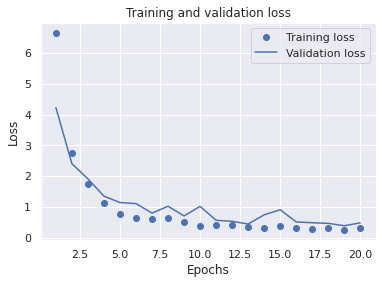

In [36]:
history_dict1 = history1.history
history_dict1.keys()
acc = history_dict1['acc']
val_acc = history_dict1['val_acc']
loss = history_dict1['loss']
val_loss = history_dict1['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [37]:
history2 = model.fit(features_train, labels_train, epochs=25, validation_data=(features_validation, labels_validation))
prediction_features = model.predict(features_test)
performance = model.evaluate(features_test, labels_test)
print(performance)
 

Epoch 1/25
157/157 [==============================] - 1s 5ms/step - loss: 0.2779 - acc: 0.9341 - val_loss: 0.4152 - val_acc: 0.9169
Epoch 2/25
157/157 [==============================] - 1s 4ms/step - loss: 0.2027 - acc: 0.9458 - val_loss: 0.2981 - val_acc: 0.9225
Epoch 3/25
157/157 [==============================] - 1s 4ms/step - loss: 0.2664 - acc: 0.9363 - val_loss: 0.3929 - val_acc: 0.9081
Epoch 4/25
157/157 [==============================] - 1s 5ms/step - loss: 0.2318 - acc: 0.9434 - val_loss: 0.4838 - val_acc: 0.9050
Epoch 5/25
157/157 [==============================] - 1s 4ms/step - loss: 0.2100 - acc: 0.9470 - val_loss: 0.3120 - val_acc: 0.9193
Epoch 6/25
157/157 [==============================] - 1s 4ms/step - loss: 0.2064 - acc: 0.9496 - val_loss: 0.3869 - val_acc: 0.9257
Epoch 7/25
157/157 [==============================] - 1s 4ms/step - loss: 0.1918 - acc: 0.9510 - val_loss: 0.3966 - val_acc: 0.9177
Epoch 8/25
157/157 [==============================] - 1s 4ms/step - loss: 0.

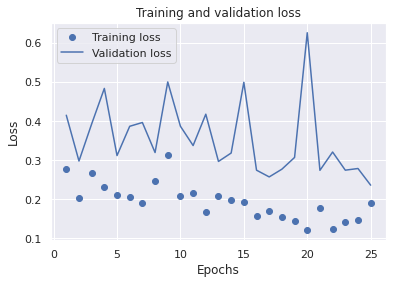

In [38]:
history_dict2 = history2.history
history_dict2.keys()
acc = history_dict2['acc']
val_acc = history_dict2['val_acc']
loss = history_dict2['loss']
val_loss = history_dict2['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()
 

In [39]:
history3 = model.fit(features_train, labels_train, epochs=15, validation_data=(features_validation, labels_validation))
prediction_features = model.predict(features_test)
performance = model.evaluate(features_test, labels_test)
print(performance)

Epoch 1/15
157/157 [==============================] - 1s 5ms/step - loss: 0.1394 - acc: 0.9626 - val_loss: 0.2381 - val_acc: 0.9465
Epoch 2/15
157/157 [==============================] - 1s 4ms/step - loss: 0.1320 - acc: 0.9658 - val_loss: 0.2693 - val_acc: 0.9353
Epoch 3/15
157/157 [==============================] - 1s 5ms/step - loss: 0.1181 - acc: 0.9638 - val_loss: 0.2215 - val_acc: 0.9441
Epoch 4/15
157/157 [==============================] - 1s 5ms/step - loss: 0.1754 - acc: 0.9528 - val_loss: 0.3173 - val_acc: 0.9361
Epoch 5/15
157/157 [==============================] - 1s 5ms/step - loss: 0.2005 - acc: 0.9532 - val_loss: 0.2366 - val_acc: 0.9425
Epoch 6/15
157/157 [==============================] - 1s 5ms/step - loss: 0.1256 - acc: 0.9680 - val_loss: 0.2611 - val_acc: 0.9369
Epoch 7/15
157/157 [==============================] - 1s 5ms/step - loss: 0.1481 - acc: 0.9644 - val_loss: 0.2497 - val_acc: 0.9393
Epoch 8/15
157/157 [==============================] - 1s 5ms/step - loss: 0.

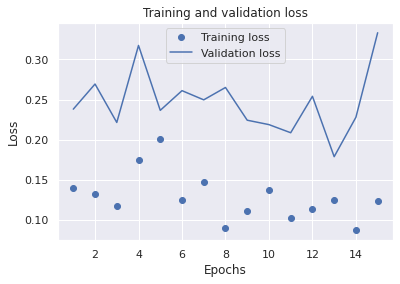

In [40]:
history_dict3 = history3.history
history_dict3.keys()
acc = history_dict3['acc']
val_acc = history_dict3['val_acc']
loss = history_dict3['loss']
val_loss = history_dict3['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [41]:
history4 = model.fit(features_train, labels_train, epochs=100, validation_data=(features_validation, labels_validation))
prediction_features = model.predict(features_test)
performance = model.evaluate(features_test, labels_test)
print(performance)

Epoch 1/100
157/157 [==============================] - 1s 5ms/step - loss: 0.1145 - acc: 0.9684 - val_loss: 0.2640 - val_acc: 0.9409
Epoch 2/100
157/157 [==============================] - 1s 5ms/step - loss: 0.1074 - acc: 0.9698 - val_loss: 0.2840 - val_acc: 0.9361
Epoch 3/100
157/157 [==============================] - 1s 5ms/step - loss: 0.1358 - acc: 0.9640 - val_loss: 0.3131 - val_acc: 0.9369
Epoch 4/100
157/157 [==============================] - 1s 5ms/step - loss: 0.1092 - acc: 0.9678 - val_loss: 0.2734 - val_acc: 0.9353
Epoch 5/100
157/157 [==============================] - 1s 4ms/step - loss: 0.0928 - acc: 0.9730 - val_loss: 0.2410 - val_acc: 0.9465
Epoch 6/100
157/157 [==============================] - 1s 4ms/step - loss: 0.1042 - acc: 0.9742 - val_loss: 0.3026 - val_acc: 0.9321
Epoch 7/100
157/157 [==============================] - 1s 5ms/step - loss: 0.0989 - acc: 0.9744 - val_loss: 0.1974 - val_acc: 0.9505
Epoch 8/100
157/157 [==============================] - 1s 5ms/step - 

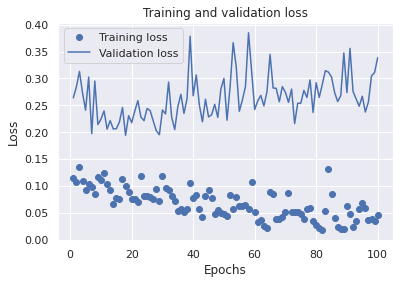

In [42]:
history_dict4 = history4.history
history_dict4.keys()
acc = history_dict4['acc']
val_acc = history_dict4['val_acc']
loss = history_dict4['loss']
val_loss = history_dict4['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

It seems that from this graph that my model is over fitting, great. Screams in pillow. lets try running it after some cross validation

### Using Grid Search Optimizing and Testing which algorithm performs the best

In [43]:
models = ['K-Nearest-Neighbors', 'Logistic Regression', 'Stochastic Gradient Descent', 'Gaussian Naive-Bayes', 'Random Forest']

In [44]:
%%time 
# takes a long time. 3min 19s

# model test scores
test_accs = []
test_recalls = []

# Get best test scores

knn = KNeighborsClassifier()
pipe = Pipeline([('KNN', knn)])


#n_params = [1]
# Use plot above to choose params for GridSearchCV
n_params = [1, 2, 3 ,4 ,5]

param_grid = {
    'KNN__n_neighbors': n_params
}

search = GridSearchCV(pipe, param_grid, cv=2, scoring='recall' )
search.fit(np.concatenate((X_train, X_valid)), np.concatenate((y_train, y_valid)))
test_recall = recall_score(search.predict(X_test), y_test)
test_recalls.append(test_recall)

search = GridSearchCV(pipe, param_grid, cv=2, scoring='accuracy' )
search.fit(np.concatenate((X_train, X_valid)), np.concatenate((y_train, y_valid)))
test_acc = accuracy_score(search.predict(X_test), y_test)
test_accs.append(test_acc)
 

CPU times: user 1min 40s, sys: 1.66 ms, total: 1min 40s
Wall time: 1min 40s


In [45]:
print('Best params for KNN',search.best_params_)
print('Best recall for KNN',test_recall)
print('Best accuracy for KNN',test_acc)

Best params for KNN {'KNN__n_neighbors': 1}
Best recall for KNN 0.9981949458483754
Best accuracy for KNN 0.9867007672634271


In [46]:
%%time
# Logistic Regression
C_params = [.9, .95, 1]

param_grid = {
    'lr__C': C_params
}

lr = LogisticRegression(random_state = 69)
pipe = Pipeline([('lr', lr)])

search = GridSearchCV(pipe, param_grid, cv=2, scoring='recall' )
search.fit(np.concatenate((X_train, X_valid)), np.concatenate((y_train, y_valid)))

test_recall = recall_score(search.predict(X_test), y_test)
test_recalls.append(test_recall)

search = GridSearchCV(pipe, param_grid, cv=2, scoring='accuracy' )
search.fit(np.concatenate((X_train, X_valid)), np.concatenate((y_train, y_valid)))

test_acc = accuracy_score(search.predict(X_test), y_test)
test_accs.append(test_acc)

# test scores

CPU times: user 3.32 s, sys: 1.34 s, total: 4.66 s
Wall time: 2.38 s


In [47]:
print('Best params for LogReg',search.best_params_)
print('Best recall for LogReg',test_recall)
print('Best accuracy for LogReg',test_acc)

Best params for LogReg {'lr__C': 0.95}
Best recall for LogReg 0.9728260869565217
Best accuracy for LogReg 0.7488491048593351


In [48]:
%%time
# SGDC
alpha_params = [.000001, .00001, .0001, .001, .01]

param_grid = {
    'SGDC__alpha': alpha_params
}

SGDC = SGDClassifier(random_state = 69)
pipe = Pipeline([('SGDC', SGDC)])

search = GridSearchCV(pipe, param_grid, cv=2, scoring='recall' )
search.fit(np.concatenate((X_train, X_valid)), np.concatenate((y_train, y_valid)))

test_recall = recall_score(search.predict(X_test), y_test)
test_recalls.append(test_recall)

search = GridSearchCV(pipe, param_grid, cv=2, scoring='accuracy' )
search.fit(np.concatenate((X_train, X_valid)), np.concatenate((y_train, y_valid)))

test_acc = accuracy_score(search.predict(X_test), y_test)
test_accs.append(test_acc)

# test scores

CPU times: user 3.72 s, sys: 2.32 s, total: 6.05 s
Wall time: 3.47 s


In [49]:
print('Best params for SGD',search.best_params_)
print('Best recall for SGD',test_recall)
print('Best accuracy for SGD',test_acc)

Best params for SGD {'SGDC__alpha': 0.001}
Best recall for SGD 0.4881291547958215
Best accuracy for SGD 0.7746803069053708


In [50]:
%%time
var_params = [1e-7, 1e-8, 1e-9, 1e-10, 1e-11]

param_grid = {
    'nb__var_smoothing': var_params
}

nb = GaussianNB()
pipe = Pipeline([('nb', nb)])

search = GridSearchCV(pipe, param_grid, cv=2, scoring='recall' )
search.fit(np.concatenate((X_train, X_valid)), np.concatenate((y_train, y_valid)))

test_recall = recall_score(search.predict(X_test), y_test)
test_recalls.append(test_recall)

search = GridSearchCV(pipe, param_grid, cv=2, scoring='accuracy' )
search.fit(np.concatenate((X_train, X_valid)), np.concatenate((y_train, y_valid)))

test_acc = accuracy_score(search.predict(X_test), y_test)
test_accs.append(test_acc)

# test scores

CPU times: user 493 ms, sys: 97.6 ms, total: 591 ms
Wall time: 505 ms


In [51]:
print('Best params for NB',search.best_params_)
print('Best recall for NB',test_recall)
print('Best accuracy for NB',test_acc)

Best params for NB {'nb__var_smoothing': 1e-07}
Best recall for NB 0.9368231046931408
Best accuracy for NB 0.951918158567775


In [52]:
%%time
depth_params = [2, 3, 5, 7, 8, 10]

param_grid = {
    'rf__max_depth': depth_params
}

rf = RandomForestClassifier(random_state = 69)
pipe = Pipeline([('rf', rf)])

search = GridSearchCV(pipe, param_grid, cv=2, scoring='recall' )
search.fit(np.concatenate((X_train, X_valid)), np.concatenate((y_train, y_valid)))

test_recall = recall_score(search.predict(X_test), y_test)
print(test_recall)
test_recalls.append(test_recall)

search = GridSearchCV(pipe, param_grid, cv=2, scoring='accuracy' )
search.fit(np.concatenate((X_train, X_valid)), np.concatenate((y_train, y_valid)))

test_acc = accuracy_score(search.predict(X_test), y_test)
print(test_acc)
test_accs.append(test_acc)

# test scores

0.9916897506925207
0.9767263427109975
CPU times: user 44.9 s, sys: 22.3 ms, total: 44.9 s
Wall time: 45 s


In [53]:
print('Best params for Random Forest',search.best_params_)
print('Best recall for Random Forest',test_recall)
print('Best accuracy for Random Forest',test_acc)

Best params for Random Forest {'rf__max_depth': 10}
Best recall for Random Forest 0.9916897506925207
Best accuracy for Random Forest 0.9767263427109975


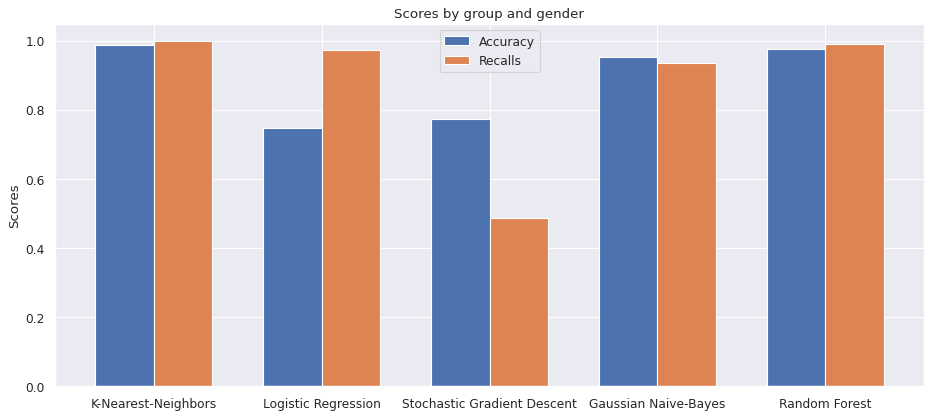

In [54]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')


N = 5
ind = np.arange(N) 
width = .35
 
plt.bar(ind, test_accs, width, label='Accuracy')
plt.bar(ind + width, test_recalls, width, label='Recalls')

plt.ylabel('Scores')
plt.title('Scores by group and gender')

plt.xticks(ind+ width / 2, models)
plt.legend(loc='best')
plt.show()